# Car Damage Assessment

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


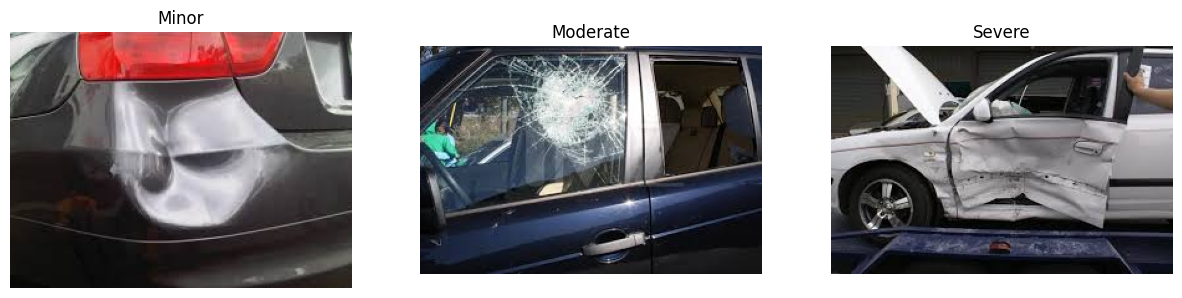

In [ ]:
import cv2
import matplotlib.pyplot as plt

dataset_path = "/content/drive/My Drive/dataset1/training"

img_paths = [
    f"{dataset_path}/01-minor/0005.JPEG",
    f"{dataset_path}/02-moderate/0016.JPEG",
    f"{dataset_path}/03-severe/0031.JPEG"
]

images = [cv2.imread(img_path) for img_path in img_paths]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Minor", "Moderate", "Severe"]

for i, ax in enumerate(axes):
    if images[i] is not None:
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax.set_title(titles[i])
        ax.axis("off")

plt.show()


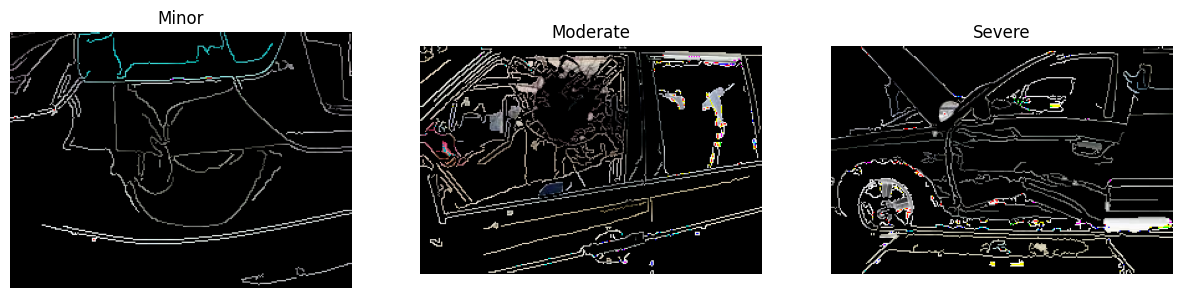

In [ ]:
def preprocess_image(image):
    """Custom preprocessing function for ImageDataGenerator."""
    # Convert image from float32 to uint8 (ImageDataGenerator provides float images)
    image = (image * 255).astype(np.uint8)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Edge detection (Canny)
    edges = cv2.Canny(blurred, 50, 150)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # mask to highlight damage
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    # Convert grayscale mask back to 3-channel
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    # Apply mask to original image
    highlighted = cv2.bitwise_and(image, mask)
    return highlighted.astype("float32") / 255.0

img_paths = [
    f"{dataset_path}/01-minor/0005.JPEG",
    f"{dataset_path}/02-moderate/0016.JPEG",
    f"{dataset_path}/03-severe/0031.JPEG"
]

processed_imgs = [preprocess_image(cv2.imread(img)) for img in img_paths]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

titles = ["Minor", "Moderate", "Severe"]
for i, ax in enumerate(axes):
    if processed_imgs[i] is not None:
        ax.imshow(cv2.cvtColor(processed_imgs[i], cv2.COLOR_BGR2RGB))
        ax.set_title(titles[i])
        ax.axis("off")

plt.show()

In [ ]:


datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/dataset1/training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/dataset1/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


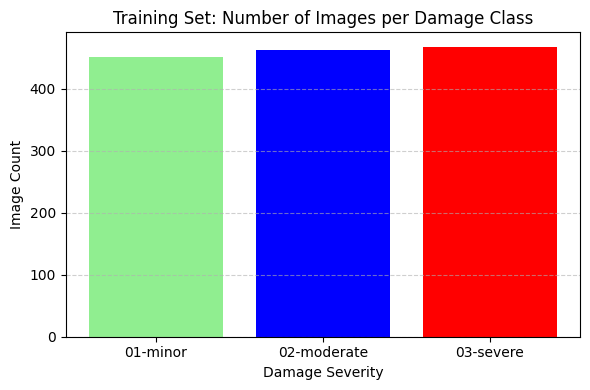

Image Count per Class: {'01-minor': 452, '02-moderate': 463, '03-severe': 468}


In [ ]:

import os
from collections import Counter
import matplotlib.pyplot as plt


train_path = '/content/drive/My Drive/dataset1/training'

# Get class names and count images
class_counts = {}
for class_name in os.listdir(train_path):
    class_folder = os.path.join(train_path, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

class_counts = dict(sorted(class_counts.items()))

plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['lightgreen', 'blue', 'red'])
plt.title('Training Set: Number of Images per Damage Class')
plt.xlabel('Damage Severity')
plt.ylabel('Image Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Image Count per Class:", class_counts)


### Resnet 50

##### 50 layers, 176 implementation layers

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=20)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 377s 8s/step - accuracy: 0.3938 - loss: 2.7551
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 620ms/step - accuracy: 0.4537 - loss: 1.0305
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 615ms/step - accuracy: 0.4811 - loss: 0.9826
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 621ms/step - accuracy: 0.4649 - loss: 1.0184
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 614ms/step - accuracy: 0.5055 - loss: 0.9654
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 614ms/step - accuracy: 0.4995 - loss: 0.9597
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 612ms/step - accuracy: 0.4999 - loss: 0.9931
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 605ms/step - accuracy: 0.4870 - loss: 0.9845
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 605ms/step - accuracy: 0.4890 - loss: 0.9833
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 613ms/step - accuracy: 0.5401 - loss: 0.9527
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 604ms/step - accuracy: 0.5120 - loss: 0.9793
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 10s/step - accuracy: 0.6755 - loss: 0.9712
Test Accuracy: 0.5121
Test Loss: 0.9942


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Keeping first layers frozen
    layer.trainable = False

optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=20)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 757ms/step - accuracy: 0.3989 - loss: 3.6955
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 620ms/step - accuracy: 0.4495 - loss: 1.5318
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 607ms/step - accuracy: 0.4648 - loss: 1.0429
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 615ms/step - accuracy: 0.5009 - loss: 0.9898
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 618ms/step - accuracy: 0.4738 - loss: 0.9985
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 610ms/step - accuracy: 0.4960 - loss: 0.9629
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 618ms/step - accuracy: 0.5265 - loss: 0.9310
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 646ms/step - accuracy: 0.5501 - loss: 0.9158
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 632ms/step - accuracy: 0.5238 - loss: 0.9295
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 653ms/step - accuracy: 0.5044 - loss: 0.9450
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 645ms/step - accuracy: 0.5165 - loss: 0.9631
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 30

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - accuracy: 0.6325 - loss: 0.8370
Test Accuracy: 0.6573
Test Loss: 0.7746


In [ ]:
model.save("resnet_DIP.h5")

## Inception V3

###### 42 layers, 315 implementation layers

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
#  InceptionV3
base_model9 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model9.layers[:-30]:  # Keeping first layers frozen
    layer.trainable = False

model_incep = Sequential([
    base_model9,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=1e-5)
model_incep.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model_incep.fit(train_generator, epochs=30)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1075s 23s/step - accuracy: 0.3577 - loss: 1.1939
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 645ms/step - accuracy: 0.4598 - loss: 1.0399
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 656ms/step - accuracy: 0.4942 - loss: 1.0059
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 651ms/step - accuracy: 0.5238 - loss: 0.9892
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 643ms/step - accuracy: 0.5561 - loss: 0.9260
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 645ms/step - accuracy: 0.5603 - loss: 0.9262
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 647ms/step - accuracy: 0.5918 - loss: 0.8934
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 649ms/step - accuracy: 0.6025 - loss: 0.8594
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.5774 - loss: 0.8580
Epoch 10/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 662ms/step - accuracy: 0.5865 - loss: 0.8544
Epoch 11/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 655ms/step - accuracy: 0.6027 - loss: 0.8316
Epoch 12/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28

In [ ]:
test_loss, test_accuracy = model_incep.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 157s 21s/step - accuracy: 0.6777 - loss: 0.7142
Test Accuracy: 0.6774
Test Loss: 0.7069


In [ ]:
model_incep.save("incep_DIP.h5")

### **Transfer learning**

### **Since our dataset is smaller and different from the ImageNet dataset, training initial layers is helpful**

In [ ]:
base_model10 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreezing initial layers (first 30)
for layer in base_model10.layers[:30]:
    layer.trainable = True

for layer in base_model10.layers[30:]:
    layer.trainable = False

model_incep10 = Sequential([
    base_model10,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=1e-5)
model_incep10.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model_incep10.fit(train_generator, epochs=30)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 628s 14s/step - accuracy: 0.3556 - loss: 1.4840
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 633ms/step - accuracy: 0.3738 - loss: 1.3225
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 650ms/step - accuracy: 0.4132 - loss: 1.2191
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 636ms/step - accuracy: 0.4058 - loss: 1.1675
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 624ms/step - accuracy: 0.4004 - loss: 1.1432
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 619ms/step - accuracy: 0.4451 - loss: 1.1070
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 621ms/step - accuracy: 0.4463 - loss: 1.0881
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 619ms/step - accuracy: 0.4294 - loss: 1.0804
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 635ms/step - accuracy: 0.5061 - loss: 1.0410
Epoch 10/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 657ms/step - accuracy: 0.4917 - loss: 1.0264
Epoch 11/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 632ms/step - accuracy: 0.4936 - loss: 1.0381
Epoch 12/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s

In [ ]:
base_model_150 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_150.layers[:150]:
    layer.trainable = True
for layer in base_model_150.layers[150:]:
    layer.trainable = False

model_150 = Sequential([
    base_model_150,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

model_150.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_150 = model_150.fit(train_generator, epochs=30)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.3712 - loss: 1.3015
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 625ms/step - accuracy: 0.4838 - loss: 1.0242
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 623ms/step - accuracy: 0.5556 - loss: 0.9446
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 640ms/step - accuracy: 0.5610 - loss: 0.9162
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 629ms/step - accuracy: 0.5734 - loss: 0.9106
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 635ms/step - accuracy: 0.5553 - loss: 0.8773
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 627ms/step - accuracy: 0.5917 - loss: 0.8637
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 629ms/step - accuracy: 0.6197 - loss: 0.8115
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 657ms/step - accuracy: 0.6144 - loss: 0.8181
Epoch 10/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 652ms/step - accuracy: 0.6057 - loss: 0.8235
Epoch 11/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 631ms/step - accuracy: 0.6540 - loss: 0.7732
Epoch 12/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 6

In [ ]:
test_loss, test_accuracy = model_150.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.7401 - loss: 0.6423
Test Accuracy: 0.6331
Test Loss: 0.8707


In [ ]:
base_model_200 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_200.layers[:200]:
    layer.trainable = True
for layer in base_model_200.layers[200:]:
    layer.trainable = False

model_200 = Sequential([
    base_model_200,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

model_200.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_200 = model_200.fit(train_generator, epochs=30)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 610s 13s/step - accuracy: 0.3382 - loss: 1.2410
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 641ms/step - accuracy: 0.5009 - loss: 0.9856
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 640ms/step - accuracy: 0.5344 - loss: 0.9304
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 652ms/step - accuracy: 0.5961 - loss: 0.8684
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 649ms/step - accuracy: 0.6191 - loss: 0.8263
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 640ms/step - accuracy: 0.6403 - loss: 0.8072
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 652ms/step - accuracy: 0.6395 - loss: 0.7900
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 653ms/step - accuracy: 0.6411 - loss: 0.7778
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 646ms/step - accuracy: 0.6579 - loss: 0.7436
Epoch 10/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 643ms/step - accuracy: 0.6702 - loss: 0.7357
Epoch 11/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 655ms/step - accuracy: 0.6555 - loss: 0.7317
Epoch 12/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s

In [ ]:
test_loss, test_accuracy = model_200.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 12s/step - accuracy: 0.6766 - loss: 0.7830
Test Accuracy: 0.6532
Test Loss: 0.8056


### Using regularization

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:

base_model_200_2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_200_2.layers[:200]:
    layer.trainable = True
for layer in base_model_200_2.layers[200:]:
    layer.trainable = False

model_200_2 = Sequential([
    base_model_200_2,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model_200_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_200_2 = model_200_2.fit(
    train_generator,
    epochs=50
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.3144 - loss: 1.9133
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 628ms/step - accuracy: 0.3850 - loss: 1.7195
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 622ms/step - accuracy: 0.5084 - loss: 1.6101
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 625ms/step - accuracy: 0.4956 - loss: 1.5860
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 617ms/step - accuracy: 0.5237 - loss: 1.5463
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 631ms/step - accuracy: 0.5451 - loss: 1.5447
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 648ms/step - accuracy: 0.5254 - loss: 1.4917
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 646ms/step - accuracy: 0.5799 - loss: 1.4720
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 653ms/step - accuracy: 0.6159 - loss: 1.4456
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 649ms/step - accuracy: 0.6027 - loss: 1.4070
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 629ms/step - accuracy: 0.5812 - loss: 1.4480
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 

In [ ]:
test_loss, test_accuracy = model_200_2.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 773ms/step - accuracy: 0.7424 - loss: 0.6443
Test Accuracy: 0.7097
Test Loss: 0.6872


In [ ]:
model_200_2.save("incep_200.h5")

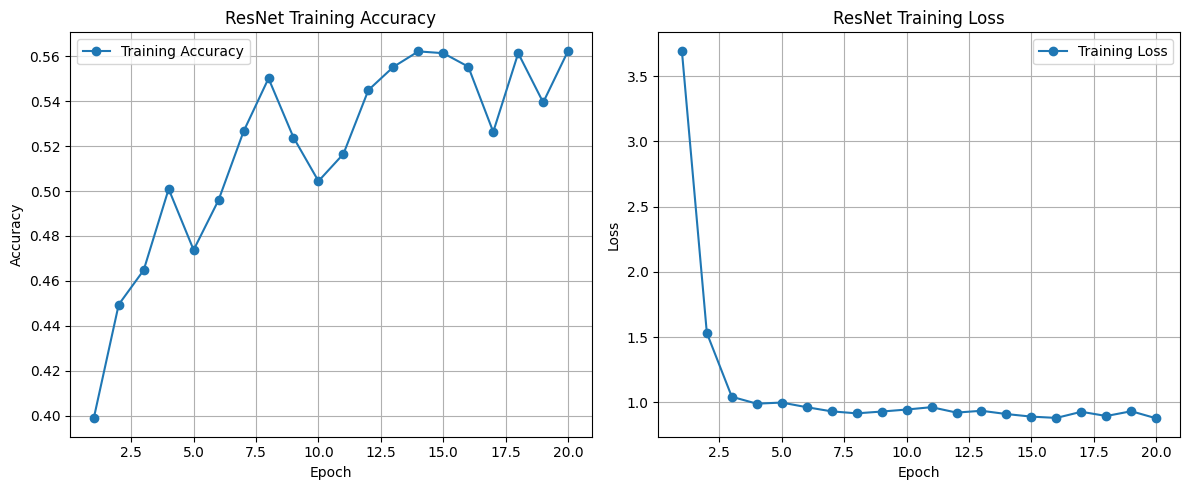

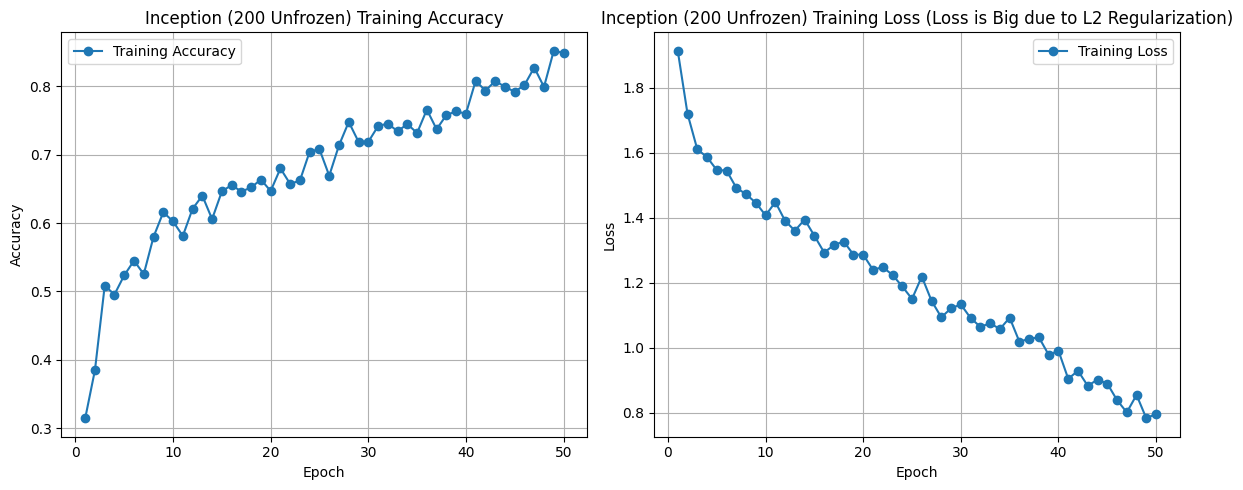

In [ ]:
import matplotlib.pyplot as plt

# Training accuracies for each model
resnet_accuracy = [0.3989, 0.4495, 0.4648, 0.5009, 0.4738, 0.4960, 0.5265, 0.5501, 0.5238, 0.5044,
                   0.5165, 0.5449, 0.5552, 0.5621, 0.5613, 0.5553, 0.5263, 0.5613, 0.5394, 0.5624]
inception_200_accuracy = [0.3144, 0.3850, 0.5084, 0.4956, 0.5237, 0.5451, 0.5254, 0.5799, 0.6159, 0.6027,
                          0.5812, 0.6210, 0.6402, 0.6059, 0.6464, 0.6558, 0.6462, 0.6522, 0.6638, 0.6470,
                          0.6801, 0.6573, 0.6625, 0.7048, 0.7081, 0.6694, 0.7139, 0.7481, 0.7191, 0.7189,
                          0.7419, 0.7458, 0.7344, 0.7450, 0.7319, 0.7661, 0.7374, 0.7582, 0.7636, 0.7601,
                          0.8083, 0.7938, 0.8080, 0.7995, 0.7922, 0.8021, 0.8277, 0.7993, 0.8523, 0.8489]


# Training losses
resnet_loss = [3.6955, 1.5318, 1.0429, 0.9898, 0.9985, 0.9629, 0.9310, 0.9158, 0.9295, 0.9450,
               0.9631, 0.9215, 0.9355, 0.9104, 0.8906, 0.8808, 0.9278, 0.8954, 0.9320, 0.8775]
inception_200_loss = [1.9133, 1.7195, 1.6101, 1.5860, 1.5463, 1.5447, 1.4917, 1.4720, 1.4456, 1.4070,
                    1.4480, 1.3899, 1.3599, 1.3942, 1.3440, 1.2927, 1.3158, 1.3266, 1.2863, 1.2861,
                    1.2395, 1.2478, 1.2238, 1.1883, 1.1501, 1.2188, 1.1440, 1.0935, 1.1214, 1.1330,
                    1.0913, 1.0642, 1.0752, 1.0574, 1.0923, 1.0184, 1.0275, 1.0317, 0.9781, 0.9906,
                    0.9044, 0.9291, 0.8828, 0.9019, 0.8896, 0.8389, 0.8012, 0.8547, 0.7828, 0.7970]

epochs_resnet = range(1, len(resnet_accuracy) + 1)
epochs_inception_200 = range(1, len(inception_200_accuracy) + 1)


# Plotting for ResNet (Accuracy and Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_resnet, resnet_accuracy, marker='o', label='Training Accuracy')
plt.title('ResNet Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_resnet, resnet_loss, marker='o', label='Training Loss')
plt.title('ResNet Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Plotting for Inception (200 Unfrozen) (Accuracy and Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_inception_200, inception_200_accuracy, marker='o', label='Training Accuracy')
plt.title('Inception (200 Unfrozen) Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_inception_200, inception_200_loss, marker='o', label='Training Loss')
plt.title('Inception (200 Unfrozen) Training Loss (Loss is Big due to L2 Regularization)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 8s/step


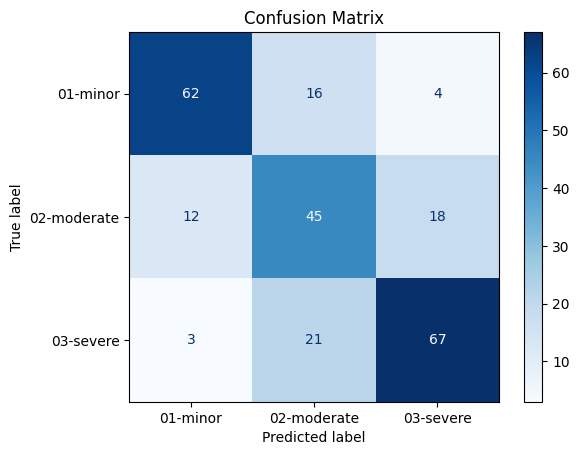

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

model = tf.keras.models.load_model('incep_200.h5')

true_labels = test_generator.classes

pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)


class_names = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import cv2
from tensorflow.keras.preprocessing import image
import numpy as np

def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    edge_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    edge_array = edge_rgb / 255.0
    edge_array = np.expand_dims(edge_array, axis=0)
    return edge_array


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
model=load_model("/content/drive/MyDrive/DL project/incep_200.h5")


In [ ]:
import matplotlib.pyplot as plt

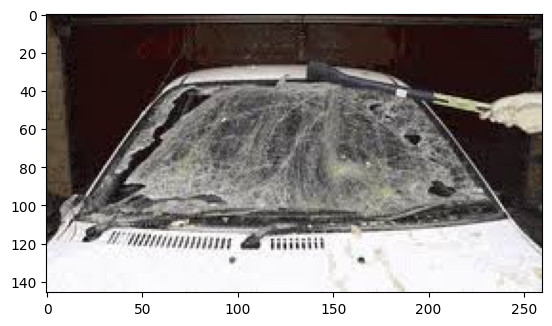

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Predicted class index: 0
Predicted class: minor


In [ ]:
img_path = "/content/drive/My Drive/dataset1/training/02-moderate/images - 2022-12-13T213955.147.jpeg"

img_array = load_image(img_path)


plt.imshow(cv2.imread(img_path)[..., ::-1])
plt.show()

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
print("Predicted class index:", predicted_class)
class_labels = ['minor','moderate', 'severe'] # since the labels are like that
print("Predicted class:", class_labels[predicted_class])

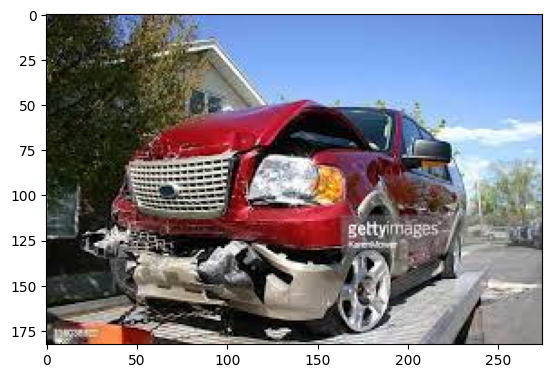

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted class index: 2
Predicted class: severe


In [ ]:
img_path = "/content/drive/My Drive/dataset1/training/02-moderate/images (75).jpeg"

img_array = load_image(img_path)


plt.imshow(cv2.imread(img_path)[..., ::-1])
plt.show()

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
print("Predicted class index:", predicted_class)
class_labels = ['minor','moderate', 'severe']
print("Predicted class:", class_labels[predicted_class])

In [ ]:
print(test_generator.class_indices)

{'01-minor': 0, '02-moderate': 1, '03-severe': 2}
